In [11]:
subj = "Subj1"
exp = "exp_sep2"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = (exp != "reproduction")
scale = False

### Imports

In [12]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [13]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
features = df_features.to_numpy()
print('Features: ', features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 64)


In [14]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    if exp != "reproduction": features = features[:-2]

### SDA

In [15]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1046 samples with 64 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [16]:
if exp != "reproduction":
    edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
    print(edges_true)

    metrics = [ ]
    for row in  tqdm.tqdm(result['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0   39  282  492  560  682  784  857  976 1046]


100%|██████████| 2016/2016 [00:06<00:00, 294.54it/s]


In [17]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [18]:
def analyze(result: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/stats.svg")
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")

#### Internal

St_len_min  K_nb_max  N_cl_max  N_stages  Cl_cen  \
0           40        35        20         3    Mode   
1            0        35        15         4    Mode   
2           40        50        10         5    Mode   
3           40        35        15         6    Mode   
4           20        40        15         7    Mode   
5            0        40        20         8    Mode   
6           60        40        20         9  Median   
7           40        50        20        10  Median   
8           60        40        10        11    Mean   
9            0        35        20        12    Mode   
10           0        35        20        13    Mode   
11           0        40        20        14    Mode   
12           0        40        15        15    Mode   
13           0        40        15        16    Mode   

                                             St_edges  Ward_dist  Cen_dist  \
0                                 [0, 554, 682, 1046]  142064.10     37.26   
1                            [0, 210, 554, 977, 1046]   65345.91     23.61   
2                       [0, 186, 554, 682, 800, 1046]  101470.72     33.91   
3                  [0, 210, 554, 682, 856, 977, 1046]  104180.90     36.35   
4              [0, 81, 210, 554, 682, 856, 977, 1046]   86135.83     33.72   
5         [0, 81, 154, 349, 554, 682, 856, 977, 1046]   64587.70     29.45   
6    [0, 81, 210, 349, 554, 682, 784, 856, 977, 1046]   51661.14     28.73   
7   [0, 111, 204, 341, 486, 554, 682, 790, 856, 97...   41095.51     26.99   
8   [0, 136, 203, 257, 335, 471, 553, 678, 793, 85...   34644.74     25.48   
9   [0, 81, 210, 263, 349, 486, 554, 682, 790, 856...   33504.60     27.30   
10  [0, 81, 154, 210, 263, 349, 486, 554, 682, 790...   29996.29     25.87   
11  [0, 81, 154, 210, 263, 349, 459, 486, 554, 682...   27328.43     24.86   
12  [0, 81, 154, 210, 263, 349, 441, 486, 554, 682...   23413.97     23.67   
13  [0, 36, 81, 154, 210, 263, 349, 441, 486, 554,...   21872.67     23.06   

        Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold   AMI  \
0   3.62e-02    94.35      3.56      0.17       133.35          1.63  0.62   
1   3.91e-02    75.29      3.61      0.09        62.93          2.73  0.65   
2   3.81e-02    87.97      3.33      0.19       112.64          1.83  0.73   
3   3.82e-02    91.62      3.77      0.21       115.04          1.63  0.80   
4   2.07e-02    81.73      3.66      0.19        95.43          1.79  0.80   
5   1.57e-02    71.48      3.75      0.16        72.21          2.21  0.79   
6   2.47e-02    69.03      3.80      0.16        60.81          2.24  0.83   
7   1.28e-02    64.71      3.76      0.15        48.99          2.33  0.84   
8   4.16e-03    54.86      3.89      0.14        39.96          2.51  0.81   
9   2.92e-03    54.20      3.53      0.14        39.88          2.27  0.85   
10 -1.45e-03    50.41      3.80      0.13        35.92          2.49  0.83   
11 -1.35e-03    46.88      3.89      0.13        32.82          2.67  0.82   
12 -2.05e-03    43.96      4.22      0.12        28.46          2.91  0.81   
13 -7.28e-03    41.86      4.15      0.12        26.86          2.93  0.81   

     ARI   FMI  
0   0.38  0.59  
1   0.41  0.57  
2   0.52  0.63  
3   0.62  0.70  
4   0.60  0.67  
5   0.59  0.65  
6   0.65  0.70  
7   0.67  0.72  
8   0.63  0.69  
9   0.70  0.75  
10  0.66  0.71  
11  0.62  0.69  
12  0.58  0.65  
13  0.59  0.66

St_len_min  K_nb_max  N_cl_max  N_stages  Cl_cen  \
0          60        40        20         9  Median   

                                           St_edges  Ward_dist  Cen_dist  \
0  [0, 81, 210, 349, 554, 682, 784, 856, 977, 1046]   51661.14     28.73   

   Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold   AMI   ARI  \
0  0.02    69.03       3.8      0.16        60.81          2.24  0.83  0.65   

   FMI  
0  0.7

array([   0,   81,  210,  349,  554,  682,  784,  856,  977, 1046])

Silh  Cal-Har  Dav-Bold       Ward  Centr
0  0.08    25.19      2.61   20392.18  20.24
1  0.11    32.59      2.75   29417.82  20.97
2  0.05    19.10      4.01   16804.88  14.24
3  0.19   107.40      1.64   90629.32  33.91
4  0.33   153.68      1.17  115095.15  45.03
5  0.13    24.42      2.54   20034.29  21.79
6  0.19    62.56      1.61   59442.91  36.29
7  0.21    61.51      1.61   61472.55  37.40

0              1               2  \
Start-end time, sec  (9.9, 80.3)  (81.1, 198.7)  (199.5, 325.1)   
Time length, sec            70.4          117.6           125.6   
Number of epochs              81            129             139   

                                  3               4               5  \
Start-end time, sec  (325.9, 506.7)  (507.5, 620.3)  (621.1, 707.5)   
Time length, sec              180.8           112.8            86.4   
Number of epochs                205             128             102   

                                  6               7               8  
Start-end time, sec  (708.3, 770.7)  (771.5, 877.9)  (878.7, 938.7)  
Time length, sec               62.4           106.4            60.0  
Number of epochs                 72             121              69

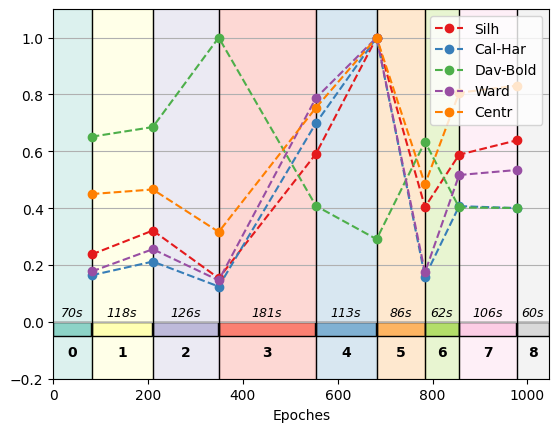

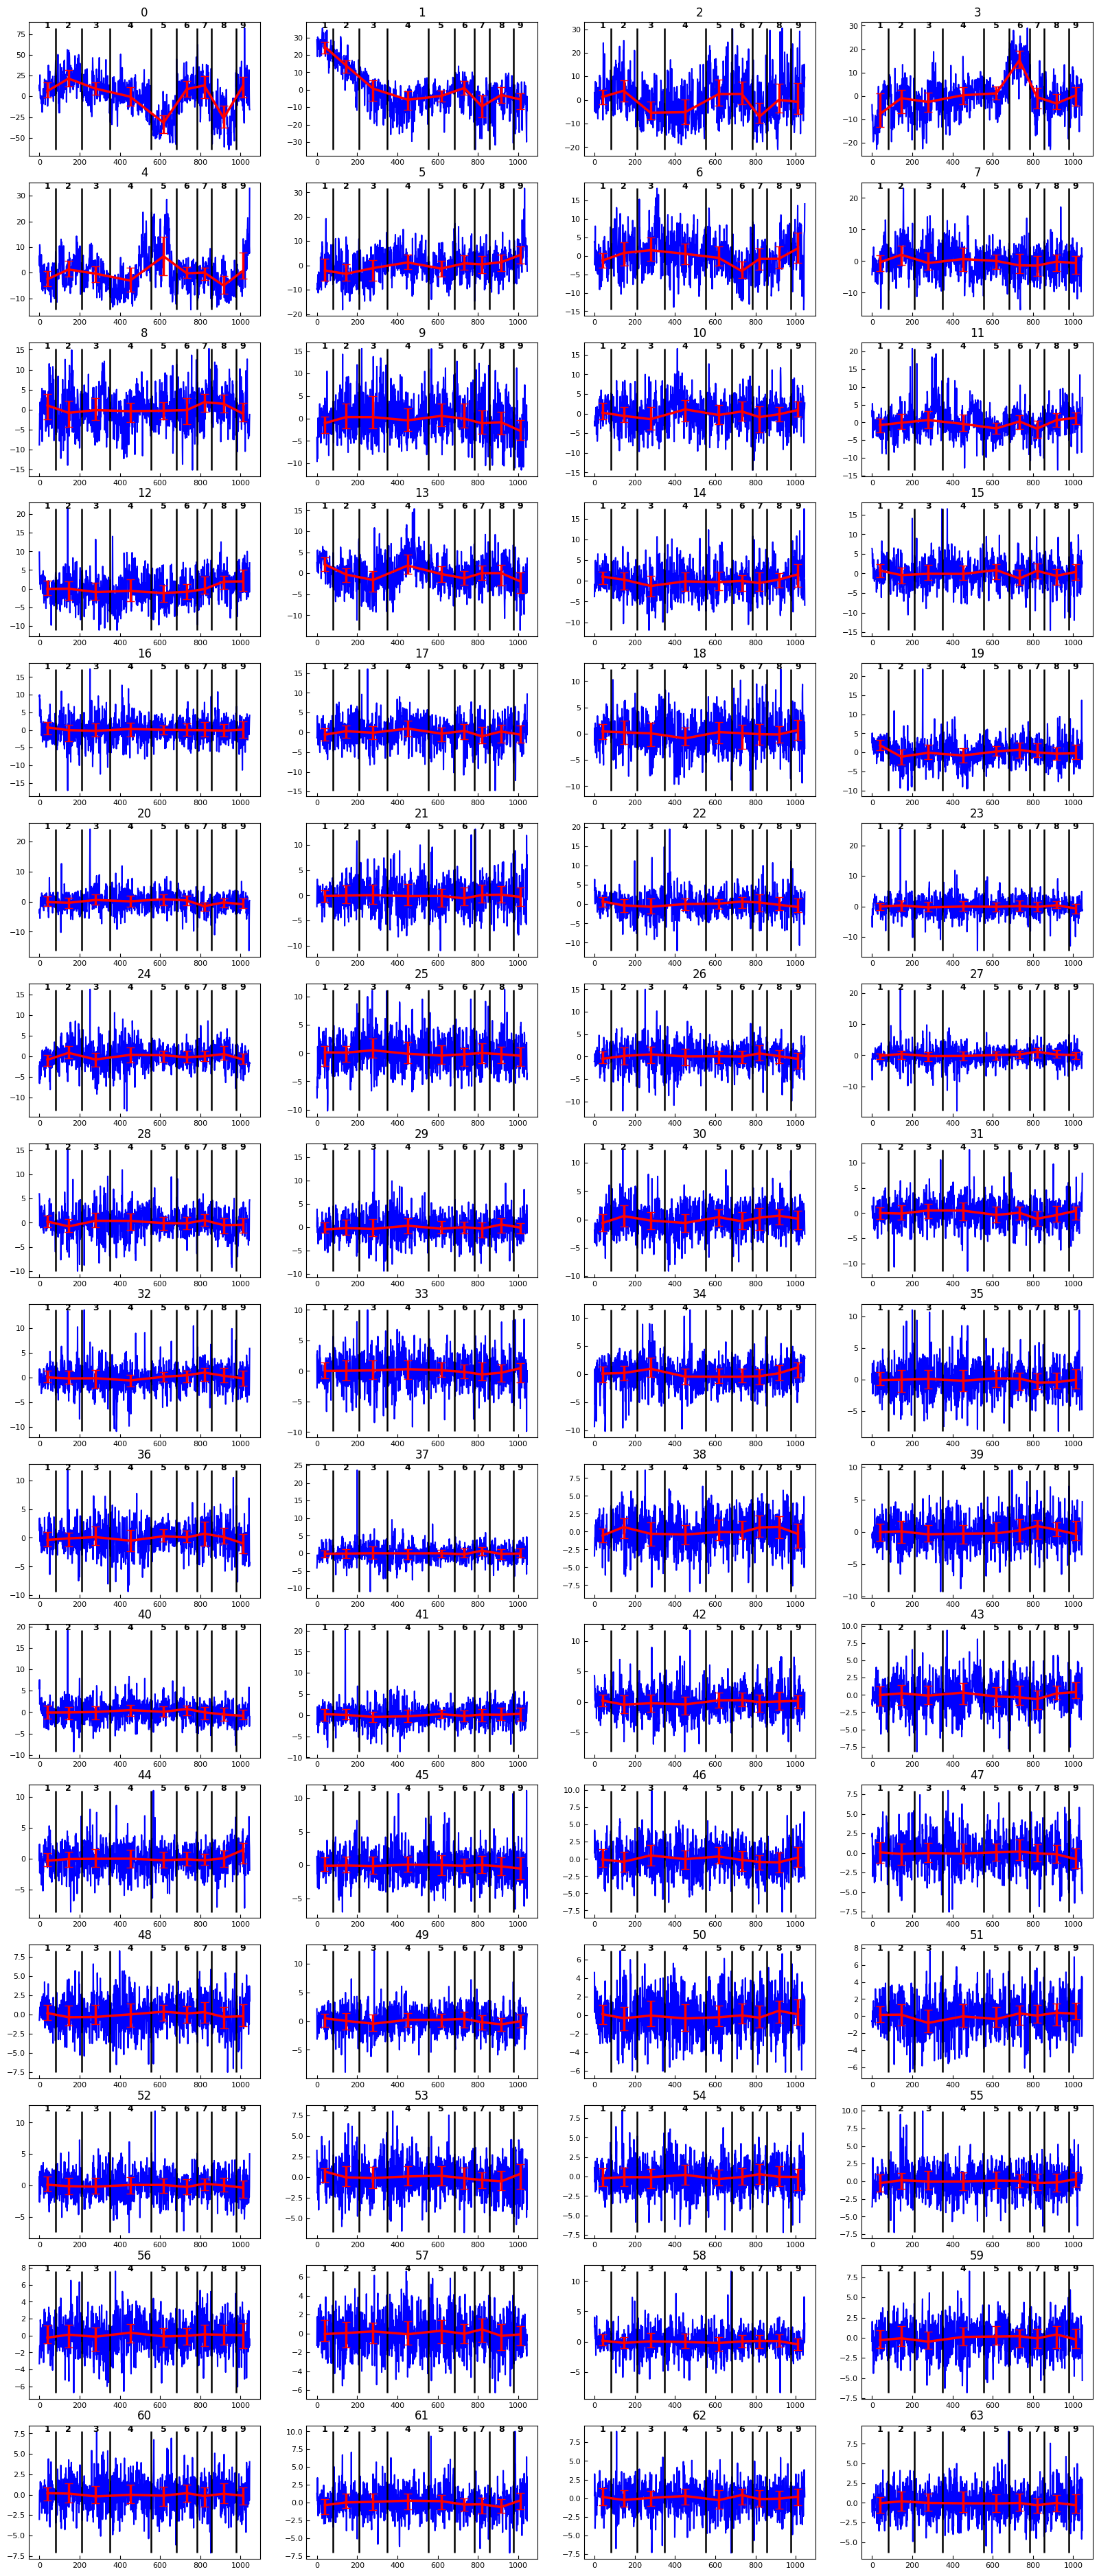

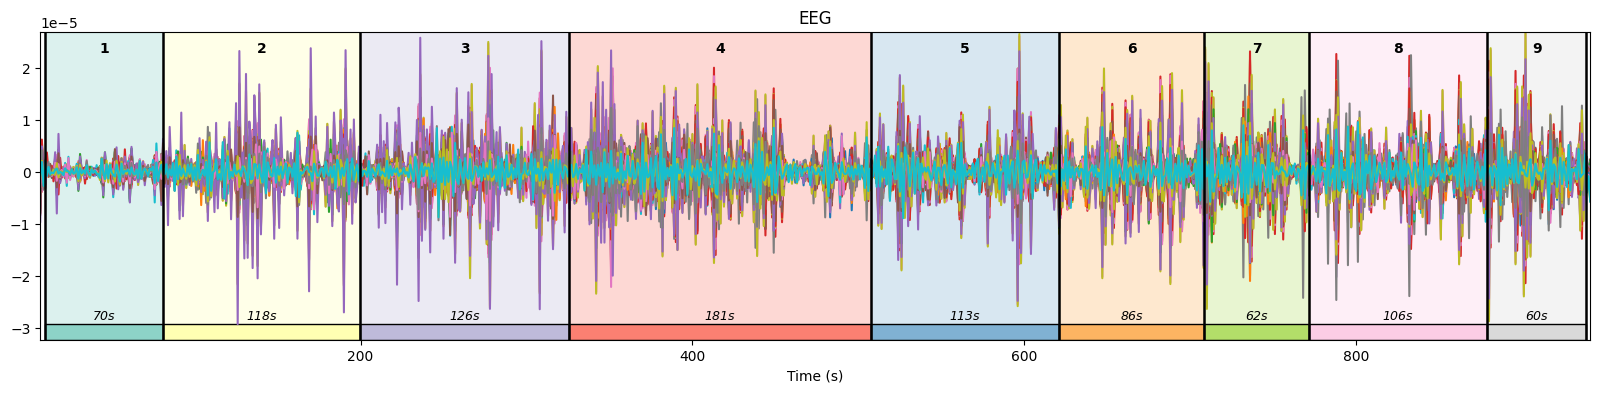

In [19]:
analyze(result, 'Avg-Silh', "internal")
# [   0   39  282  492  560  682  784  857  976 1046]
# array([   0,   46,  210,  340,  554,  682,  784,  846,  975, 1046])

![Alternative Text][1707850881559]

[1707850881559]: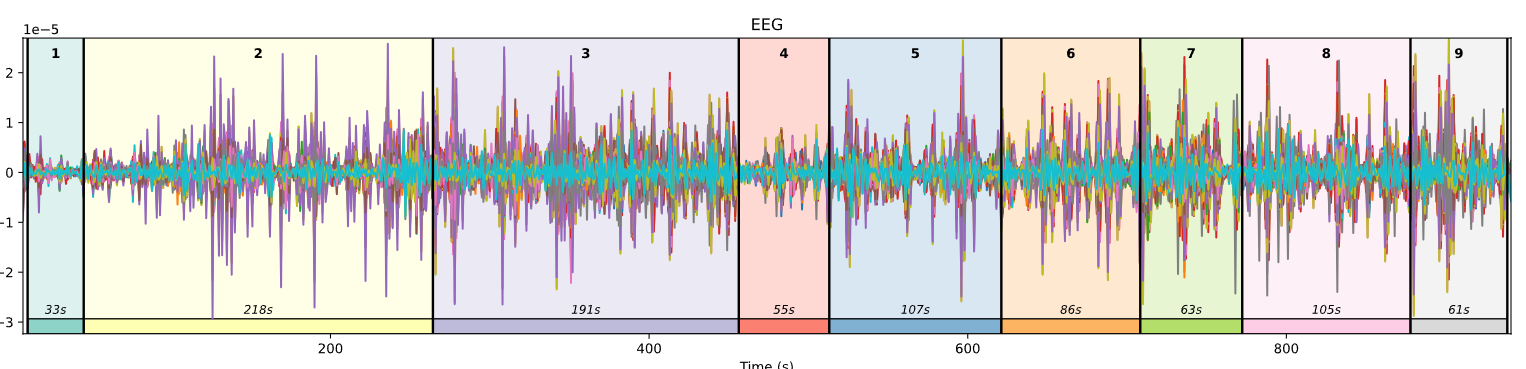

#### External

St_len_min  K_nb_max  N_cl_max  N_stages  Cl_cen  \
0           40        35        10         3    Mean   
1           20        35        20         4    Mode   
2           20        40        20         5    Mode   
3           20        35        20         6    Mode   
4            0        35        20         7  Median   
5           40        40        10         8  Median   
6           20        35        15         9    Mode   
7            0        35        15        10  Median   
8            0        35        20        11  Median   
9           20        35        20        12  Median   
10          20        40        20        13  Median   
11           0        45        15        14    Mode   
12           0        40        20        15  Median   
13           0        50        20        16    Mode   

                                             St_edges  Ward_dist  Cen_dist  \
0                                 [0, 279, 730, 1046]   75377.99     17.64   
1                            [0, 349, 554, 856, 1046]   35518.50     15.86   
2                       [0, 349, 554, 682, 856, 1046]   89015.44     31.35   
3                   [0, 36, 349, 554, 682, 856, 1046]   74510.03     30.23   
4              [0, 81, 263, 522, 681, 841, 976, 1046]   77710.48     30.96   
5        [0, 186, 284, 459, 554, 681, 842, 976, 1046]   56059.95     27.84   
6    [0, 36, 210, 349, 486, 554, 682, 856, 977, 1046]   51531.77     27.88   
7   [0, 78, 207, 303, 486, 554, 682, 790, 856, 976...   40182.49     26.66   
8   [0, 80, 192, 268, 349, 486, 554, 682, 785, 856...   35688.59     25.20   
9   [0, 36, 154, 210, 263, 349, 486, 554, 682, 784...   33210.99     25.40   
10  [0, 36, 81, 154, 210, 284, 349, 486, 554, 682,...   29461.88     23.39   
11  [0, 36, 81, 154, 210, 284, 349, 486, 554, 682,...   27224.66     24.55   
12  [0, 36, 81, 154, 204, 284, 349, 486, 554, 682,...   23153.26     22.88   
13  [0, 26, 81, 154, 186, 268, 284, 349, 486, 554,...   20783.32     22.39   

        Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold   AMI  \
0   5.00e-02    72.09      7.70      0.07        68.66          6.27  0.63   
1   1.96e-02    58.26      4.98      0.05        34.56          4.55  0.70   
2   2.47e-02    84.49      3.68      0.17        97.96          2.01  0.78   
3   4.24e-03    73.56      3.42      0.15        82.01          2.00  0.81   
4   1.84e-02    76.25      3.95      0.16        84.00          2.00  0.82   
5   1.74e-02    70.66      3.83      0.15        63.32          2.42  0.84   
6   1.72e-03    67.11      3.56      0.14        58.40          2.26  0.85   
7   8.69e-03    63.64      3.89      0.14        47.75          2.37  0.87   
8   9.66e-03    58.73      3.89      0.13        42.95          2.57  0.86   
9  -1.12e-03    55.29      3.78      0.13        40.32          2.43  0.87   
10 -2.29e-03    51.13      3.99      0.12        35.95          2.74  0.87   
11 -5.48e-03    47.22      3.79      0.12        32.82          2.63  0.86   
12 -6.26e-03    44.33      4.14      0.11        28.32          2.90  0.85   
13 -1.50e-02    40.57      4.20      0.10        25.28          3.02  0.83   

     ARI   FMI  
0   0.45  0.62  
1   0.53  0.64  
2   0.62  0.70  
3   0.67  0.73  
4   0.73  0.77  
5   0.71  0.75  
6   0.71  0.75  
7   0.77  0.80  
8   0.71  0.76  
9   0.71  0.76  
10  0.70  0.75  
11  0.68  0.74  
12  0.66  0.72  
13  0.65  0.71

St_len_min  K_nb_max  N_cl_max  N_stages Cl_cen  \
0          20        35        15         9   Mode   

                                           St_edges  Ward_dist  Cen_dist  \
0  [0, 36, 210, 349, 486, 554, 682, 856, 977, 1046]   51531.77     27.88   

       Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold   AMI  \
0  1.72e-03    67.11      3.56      0.14         58.4          2.26  0.85   

    ARI   FMI  
0  0.71  0.75

array([   0,   36,  210,  349,  486,  554,  682,  856,  977, 1046])

Silh  Cal-Har  Dav-Bold       Ward  Centr
0  0.07    22.57      1.95   18481.61  24.89
1  0.11    39.70      2.67   34973.30  21.27
2  0.05    16.16      3.99   14423.42  14.46
3  0.05    15.94      3.15   13225.93  17.06
4  0.16    47.58      1.83   34519.01  27.88
5  0.28   161.48      1.29  139277.58  43.46
6  0.21   102.29      1.60   95880.78  36.65
7  0.21    61.51      1.61   61472.55  37.40

0              1               2  \
Start-end time, sec  (9.9, 40.3)  (41.1, 198.7)  (199.5, 325.1)   
Time length, sec            30.4          157.6           125.6   
Number of epochs              36            174             139   

                                  3               4               5  \
Start-end time, sec  (325.9, 449.9)  (450.7, 506.7)  (507.5, 620.3)   
Time length, sec              124.0            56.0           112.8   
Number of epochs                137              68             128   

                                  6               7               8  
Start-end time, sec  (621.1, 770.7)  (771.5, 877.9)  (878.7, 938.7)  
Time length, sec              149.6           106.4            60.0  
Number of epochs                174             121              69

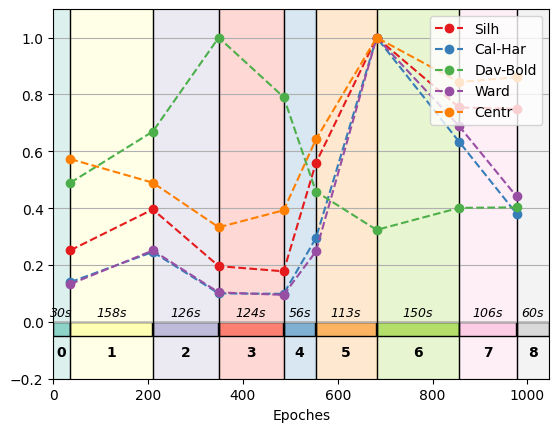

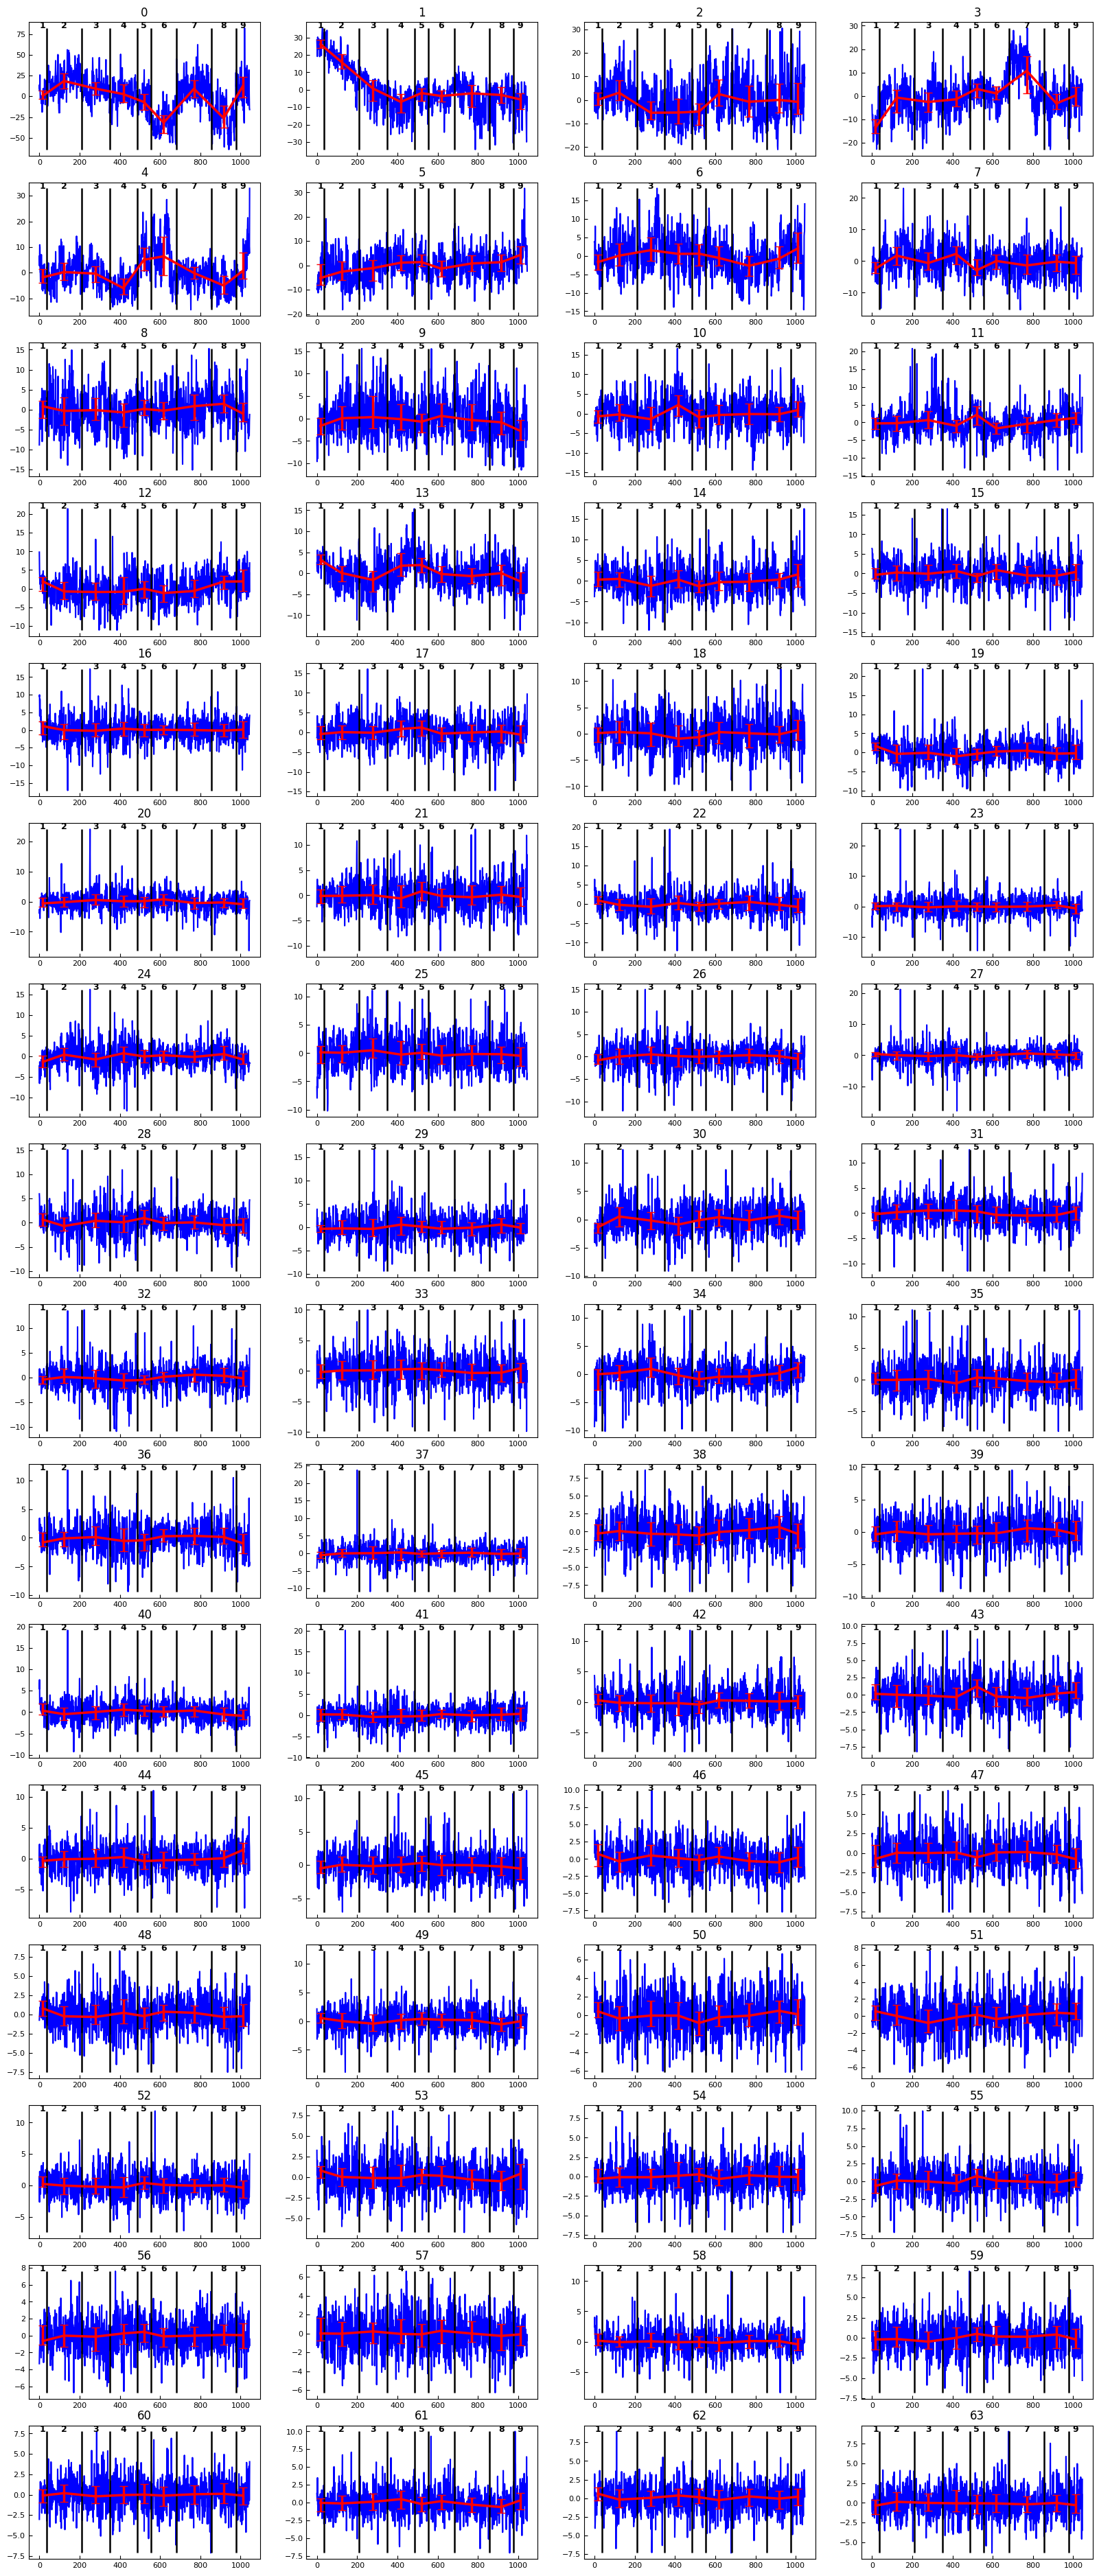

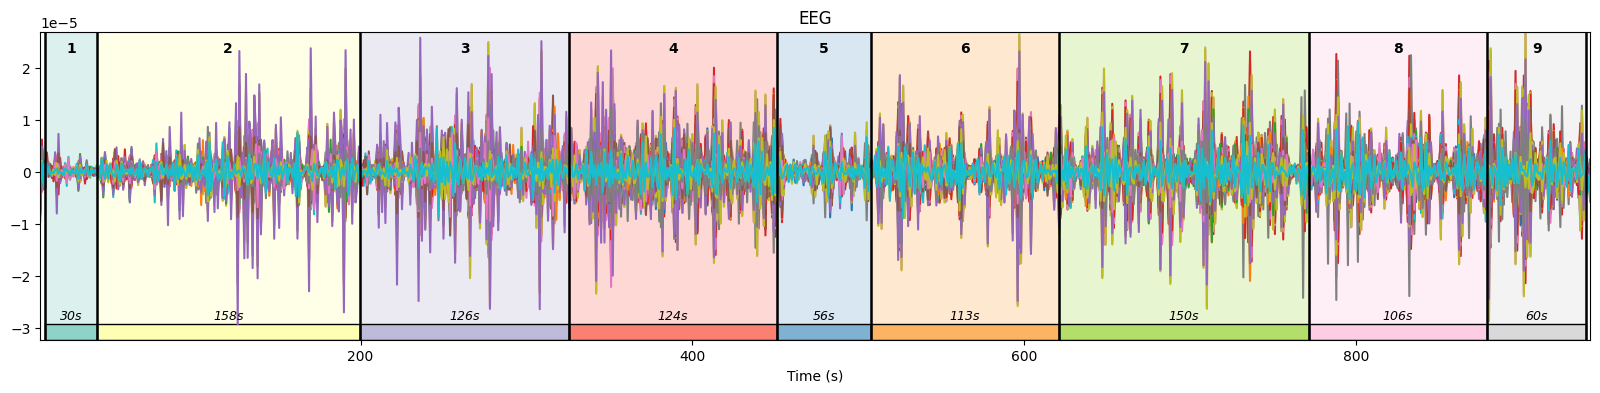

In [20]:
if exp != "reproduction":
    analyze(result, 'FMI', "external")
# [   0   39  282  492  560  682  784  857  976 1046]

![Alternative Text][1707850881559]

[1707850881559]: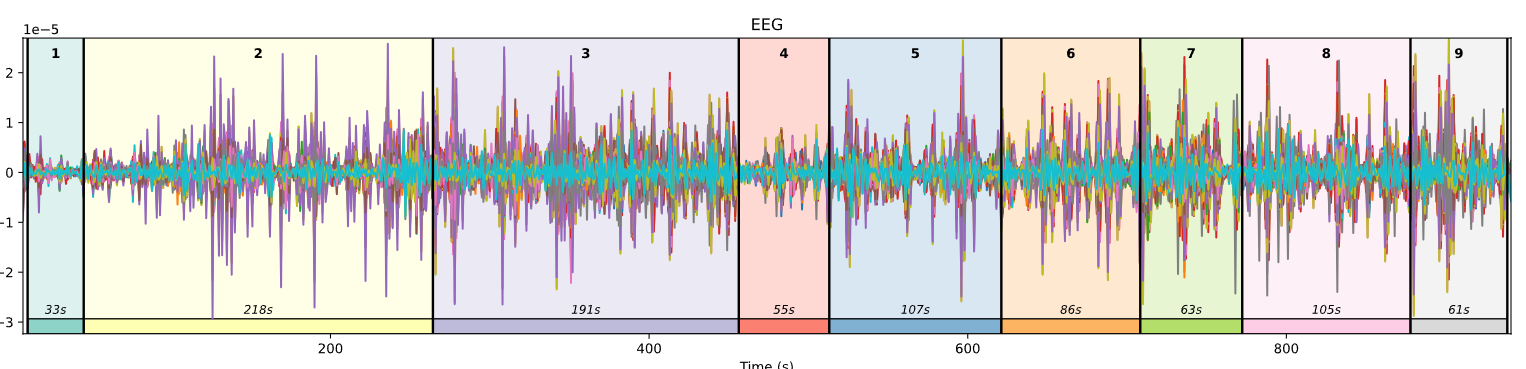